In [ ]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image, ImageOps
import pathlib
import os
import numpy as np
import datetime
%load_ext tensorboard

***
Creating Dataset so each pair of signatures will be collected together and label will be given for each pairs based on their matching status (1=Match,0=No Match)
***

In [8]:
# Create function to collect signiture in pairs, label will be set to 1 if pairs signitures are match else 0

path_master = "Dataset_Signature_Final/Dataset/"


def pair_dataset(path_master):
    
    root = tf.io.gfile.listdir(path_master)
    real_path = [path_master + i + '/real/' for i in root]
    forge_path = [path_master + i + '/forge/' for i in root]
    pairs = []
    labels = []
    person_id = '01'
    
    for path in real_path:
        dataset_files = tf.io.gfile.listdir(path)
        
        for idx,file in enumerate(dataset_files):
            if idx  == 0:
                x1 = tf.io.read_file(path +  file)
                x1 = tf.io.decode_png(x1,channels=1, dtype=tf.dtypes.uint8)
                x1 = tf.image.resize(x1,(280,280))
            
            elif idx == 1:
                x2 = tf.io.read_file(path +  file)
                x2 = tf.io.decode_png(x2,channels=1, dtype=tf.dtypes.uint8)
                x2 = tf.image.resize(x2,(280,280))
                pairs += [[x1,x2]]
                labels += [1]
            
            elif file[6:8] == person_id:
                x2 = tf.io.read_file(path +  file)
                x2 = tf.io.decode_png(x2,channels=1, dtype=tf.dtypes.uint8)
                x2 = tf.image.resize(x2,(280,280))
                pairs += [[x1,x2]]
                x1 = x2
                labels += [1]
            else:
                person_id = file[6:8]
                x1 = tf.io.read_file(path +  file)
                x1 = tf.io.decode_png(x1,channels=1, dtype=tf.dtypes.uint8)
                x1 = tf.image.resize(x1,(280,280))
    
    
    for path in forge_path:
        dataset_files = tf.io.gfile.listdir(path)
        
        for idx,file in enumerate(dataset_files):
            if idx  == 0:
                x1 = [tf.io.read_file(path +  file)]
                x1 = tf.io.decode_png(x1[0],channels=1, dtype=tf.dtypes.uint8)
                x1 = tf.image.resize(x1,(280,280))
                
            elif idx != 0:
                x2 = tf.io.read_file(path +  file)
                x2 = tf.io.decode_png(x2,channels=1, dtype=tf.dtypes.uint8)
                x2 = tf.image.resize(x2,(280,280))
                pairs += [[x1,x2]]
                labels += [0]
                x1 = x2
        
      
    pairs = np.array(pairs)
    labels = np.array(labels)
    return pairs,labels



***
Creating Training Dataset
***

In [9]:
# Creating training Data"
x_train,y_train = pair_dataset(path_master)
print('The shape for pairs', x_train.shape)
print('The shape for Labels', y_train.shape)

# Spliting the pairs into seperate inputs
x_train_input1 = x_train[:,0]
x_train_input2 = x_train[:,1]
# Casting y_train to float32
y_train = y_train.astype(np.float32)


print('The shape for input1', x_train_input1.shape)
print('The shape for input2',x_train_input2.shape)

The shape for pairs (641, 2, 280, 280, 1)
The shape for Labels (641,)
The shape for input1 (641, 280, 280, 1)
The shape for input2 (641, 280, 280, 1)


***
Creating Validation and Testing Dataset
***

In [10]:
# Creating Validation and testing data:
x_val_test , y_val_test = pair_dataset(path_master='sample_Signature/')
print('The shape for x_val_test', x_val_test.shape)
print('The Shape for y_val_test',y_val_test.shape)
x_val = np.concatenate((x_val_test[0:80] , x_val_test[-80:]), axis=0)
y_val = np.concatenate((y_val_test[0:80] , y_val_test[-80:]), axis=0)
# Casting y_val to float32
y_val = y_val.astype(np.float32)


print(f'The number of x_val is',x_val.shape[0],'and y_val records is',y_val.shape[0])
x_test = np.concatenate((x_val_test[80:138] , x_val_test[-130:-80]), axis=0)
y_test = np.concatenate((y_val_test[80:138] , y_val_test[-130:-80]), axis=0)
# Casting y_val to float32
y_test = y_test.astype(np.float32)


print('The number of x_test is',x_test.shape[0],'and the number of y_test records is',y_test.shape[0])
print('-----------------------------------------------------------------')
print("the number of  x_test and x_val records is", format(x_val.shape[0] + x_test.shape[0]))
print("the number of  y_test and y_val records is", format(y_val.shape[0] + y_test.shape[0]))

# Split the pairs into seperate inputs:
x_val_input1 = x_val[:,0]
x_val_input2 = x_val[:,1]
x_test_input1 = x_test[:,0]
x_test_input2 = x_test[:,1]
print('the number of x_val_input1 is', x_val_input1.shape[0],' and the number of x_val_input2 records is', x_val_input2.shape[0])
print('the number of  x_test_input1 is', x_test_input1.shape[0],' and the number of x_test_input2 records is',x_test_input2.shape[0])

The shape for x_val_test (268, 2, 280, 280, 1)
The Shape for y_val_test (268,)
The number of x_val is 160 and y_val records is 160
The number of x_test is 108 and the number of y_test records is 108
-----------------------------------------------------------------
the number of  x_test and x_val records is 268
the number of  y_test and y_val records is 268
the number of x_val_input1 is 160  and the number of x_val_input2 records is 160
the number of  x_test_input1 is 108  and the number of x_test_input2 records is 108


***
visualization
***

In [11]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

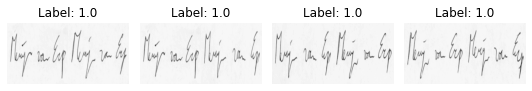

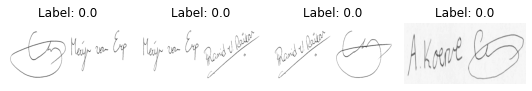

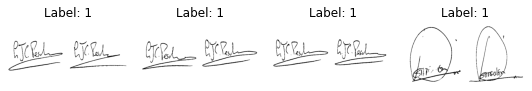

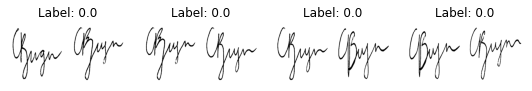

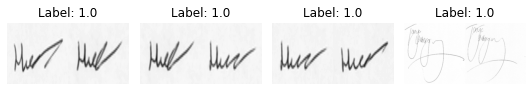

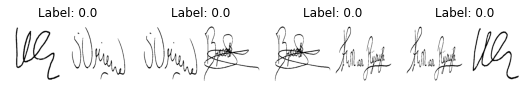

In [12]:
# visualize random sample for matching and mismatching signitures

#Training_Matching:
visualize(x_train[0:4], y_train[0:4], to_show=4, num_col=4)

#Training_Mismatching
visualize(x_train[400:405], y_train[400:405], to_show=4, num_col=4)

#Validation_Matching:
visualize(x_val_test[0:4], y_val_test[0:4], to_show=4, num_col=4)

#Validation_Mismatching:
visualize(x_val[-4:], y_val[-4:], to_show=4, num_col=4)


#Testing_Matching
visualize(x_test[0:4], y_val[0:4], to_show=4, num_col=4)

#Testing_Mismatching
visualize(x_test[-4:], y_val[-4:], to_show=4, num_col=4)

***
Creating Model
***

In [13]:
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input = layers.Input((280, 280, 1))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(4, (3, 3), activation="relu")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation="relu")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation="relu")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation="relu")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(1, activation="sigmoid")(x)
embedding_network = keras.Model(input, x)


input_1 = layers.Input((280, 280, 1))
input_2 = layers.Input((280, 280, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

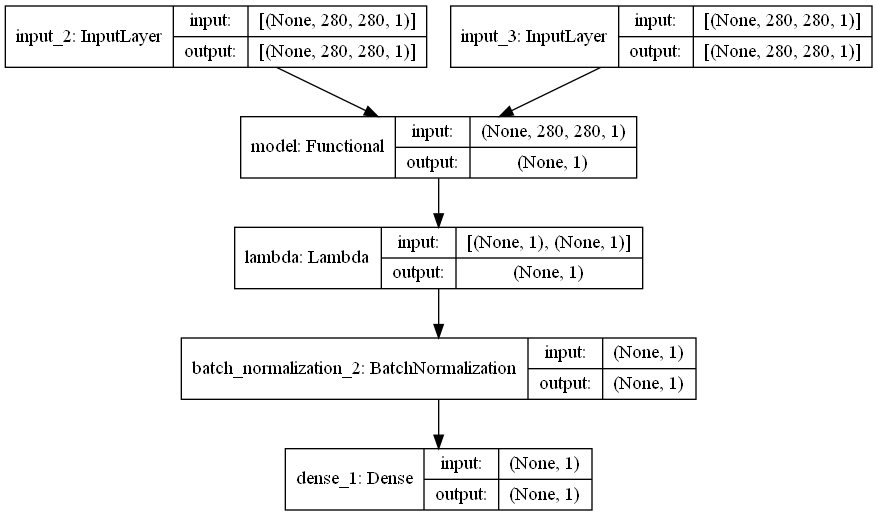

In [14]:
tf.keras.utils.plot_model(siamese, show_shapes=True)

***
Creating Loss function
***

In [15]:
def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

  Arguments:
      margin: Integer, defines the baseline for distance for which pairs
              should be classified as dissimilar. - (default is 1).

  Returns:
      'constrastive_loss' function with data ('margin') attached.
  """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

      Arguments:
          y_true: List of labels, each label is of type float32.
          y_pred: List of predictions of same length as of y_true,
                  each label is of type float32.

      Returns:
          A tensor containing constrastive loss as floating point value.
      """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

***
Compile the model
***

In [19]:
epochs = 50
batch_size = 16
margin = 1  # Margin for constrastive loss.

In [20]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


siamese.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
siamese.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 280, 280, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 280, 280, 1) 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 1)            95773       input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[0][0]                

***
Training the Model
***

In [21]:
tf.config.run_functions_eagerly(True)
history = siamese.fit(
    [x_train_input1, x_train_input2],
    y_train,
    validation_data=([x_val_input1, x_val_input2], y_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[tensorboard_callback]
)

C:\Users\Windows10-Desktop\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


Epoch 1/50
41/41 [==============================] - 51s 1s/step - loss: 0.2721 - accuracy: 0.5538 - val_loss: 0.2498 - val_accuracy: 0.4750
Epoch 2/50
41/41 [==============================] - 49s 1s/step - loss: 0.2650 - accuracy: 0.5679 - val_loss: 0.2507 - val_accuracy: 0.5000
Epoch 3/50
41/41 [==============================] - 49s 1s/step - loss: 0.2486 - accuracy: 0.5881 - val_loss: 0.2526 - val_accuracy: 0.5500
Epoch 4/50
41/41 [==============================] - 49s 1s/step - loss: 0.2257 - accuracy: 0.6599 - val_loss: 0.2287 - val_accuracy: 0.6687
Epoch 5/50
41/41 [==============================] - 49s 1s/step - loss: 0.2105 - accuracy: 0.6864 - val_loss: 0.2131 - val_accuracy: 0.7000
Epoch 6/50
41/41 [==============================] - 49s 1s/step - loss: 0.2007 - accuracy: 0.7207 - val_loss: 0.1685 - val_accuracy: 0.8500
Epoch 7/50
41/41 [==============================] - 48s 1s/step - loss: 0.1752 - accuracy: 0.7878 - val_loss: 0.1797 - val_accuracy: 0.7500
Epoch 8/50
41/41 [==

***
Tensorboard
***

In [22]:
%tensorboard --logdir logs/fit

***
Evaluation
***

In [26]:
results = siamese.evaluate([x_test_input1, x_test_input2], y_test)
print("test loss, test acc:", results)

4/4 [==============================] - 2s 399ms/step - loss: 0.1365 - accuracy: 0.8519
test loss, test acc: [0.13645385205745697, 0.8518518805503845]


***
Prediction
***

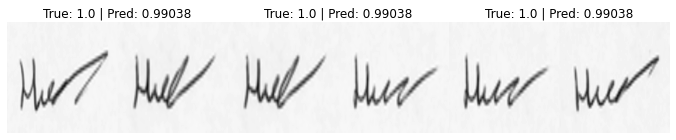

In [403]:
#Matching cases:
predictions = siamese.predict([x_test_input1[:3], x_test_input2[:3]])
visualize(x_test[:3], y_test[:3], to_show=3, predictions=predictions, test=True)

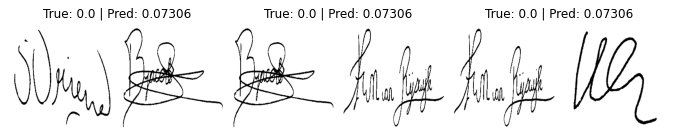

In [24]:
# Nonmatching cases:
predictions = siamese.predict([x_test_input1[-3:], x_test_input2[-3:]])
visualize(x_test[-3:], y_test[-3:], to_show=3, predictions=predictions, test=True)

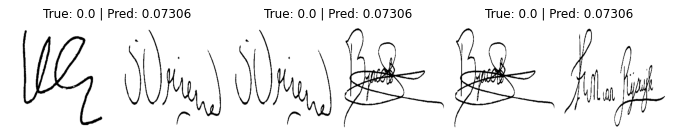

In [31]:
# Random cases:
predictions = siamese.predict([x_test_input1[104:107], x_test_input2[104:107]])
visualize(x_test[104:107], y_test[104:107], to_show=3, predictions=predictions, test=True)

***
Saving the model
***

In [405]:
tf.keras.models.save_model(siamese, 'model_signiture')

INFO:tensorflow:Assets written to: model_signiture\assets
